# Allstate Claims Severity EDA (Kaggle) - Charles Lamb

# Table of Contents

### <a href='#week1'>Jump to Week 1</a>

### <a href='#week2'>Jump to Week 2</a>

<a href='#holdout'>Holdout Data Setup</a>

<a href='#lin_model'>Linear Regression - 944 dfs</a>

<a href='#reduced_lin_model'>Linear Regression after Backward Selection- 54 dfs</a>

<a href='#pol_reg'>Polynomical Fit - 55 dfs</a>

<a href='#piecewise'>Piecewise Fit</a>

<a href='#kaggle'>Kaggle Submissiona and Score</a>

<a href='#interpretation'>How to Interpret the Model</a>

### <a href='#week3'>Jump to Week 3</a>

<a href='#log_trans'>Log Transformation</a>

<a href='#Lasso'>Lasso</a>

<a href='#Ridge'>Ridge</a>

<a href='#elastic'>ElasticNet</a>

<a href='#kaggle2'>Final Kaggle Submission</a>

# Week 1 - EDA <a id=’week1’></a>

### Management Question

<font color='red'>Can we use avialable information to predict claim amount (severity)?  The business case is the ability to predict severity could allow the insurer to automate part or all of the claim process.  For example, if Allstate can predict which claims will settle for a small amount they could justify forgoing a number of approvals and steps currently required to get those claims paid.  There could be substantial benefits to both insurer and claimant.  The insurer benefis from lower expenses associated with streamling part of their operation.  The claimant benefits from getting paid faster with less demands for documentation and less phone calls. </font>

### Imports and Data Load

In [1]:
#conda install -c conda-forge pwlf

In [2]:
import math
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import asarray
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet

In [3]:
df = pd.read_csv("train.csv")
df.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


### Looking at variables and shape of data

In [4]:
df.shape

(188318, 132)

In [5]:
df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Data columns (total 132 columns):
 #    Column  Non-Null Count   Dtype  
---   ------  --------------   -----  
 0    id      188318 non-null  int64  
 1    cat1    188318 non-null  object 
 2    cat2    188318 non-null  object 
 3    cat3    188318 non-null  object 
 4    cat4    188318 non-null  object 
 5    cat5    188318 non-null  object 
 6    cat6    188318 non-null  object 
 7    cat7    188318 non-null  object 
 8    cat8    188318 non-null  object 
 9    cat9    188318 non-null  object 
 10   cat10   188318 non-null  object 
 11   cat11   188318 non-null  object 
 12   cat12   188318 non-null  object 
 13   cat13   188318 non-null  object 
 14   cat14   188318 non-null  object 
 15   cat15   188318 non-null  object 
 16   cat16   188318 non-null  object 
 17   cat17   188318 non-null  object 
 18   cat18   188318 non-null  object 
 19   cat19   188318 non-null  object 
 20   cat20   188318 non-null 

### Missing data

<font color='red'> We can see from df.info() above that there are no-null values.  We can also double check this way </font>

In [6]:
#double checking no null values
df.isna().sum().sum()

0

### Check for 0 values in Loss

In [7]:
sum(df['loss'] == 0)

0

<font color='red'> Sometimes insurance companies have claims where they pay no money.  For instance, this might happen when the insurer denies the claim.  These claims can be hard to predict, but thankful these types of claims are not included in this data </font>

### Marginal Distribution of the Dependent Variable

[Text(0.5, 1.0, 'Loss <= 15000')]

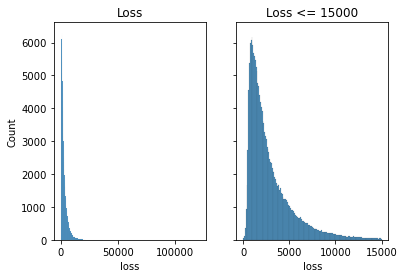

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.histplot(data=df.loss,ax=ax1).set(title="Loss")
sns.histplot(data=df[df.loss<=15000].loss,ax=ax2).set(title="Loss <= 15000")

In [9]:
df['loss'].describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

<a id='log_trans'></a>
### Log Transformation on Loss

[Text(0.5, 1.0, 'logloss')]

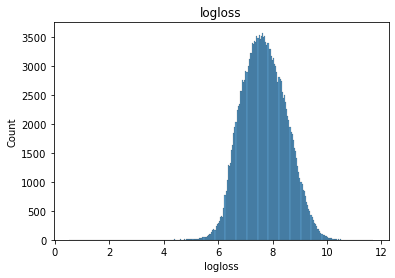

In [10]:
#performing a log transformation of loss
#we will train on the log transformed data
df['logloss'] = np.log(df['loss']+1)
sns.histplot(data=df.logloss).set(title="logloss")

### Indepedent Variable (Numerical) - Marginal Distributions and Correlations

In [11]:
df_num = df.select_dtypes(include = ['float64'])
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Data columns (total 16 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   cont1    188318 non-null  float64
 1   cont2    188318 non-null  float64
 2   cont3    188318 non-null  float64
 3   cont4    188318 non-null  float64
 4   cont5    188318 non-null  float64
 5   cont6    188318 non-null  float64
 6   cont7    188318 non-null  float64
 7   cont8    188318 non-null  float64
 8   cont9    188318 non-null  float64
 9   cont10   188318 non-null  float64
 10  cont11   188318 non-null  float64
 11  cont12   188318 non-null  float64
 12  cont13   188318 non-null  float64
 13  cont14   188318 non-null  float64
 14  loss     188318 non-null  float64
 15  logloss  188318 non-null  float64
dtypes: float64(16)
memory usage: 23.0 MB


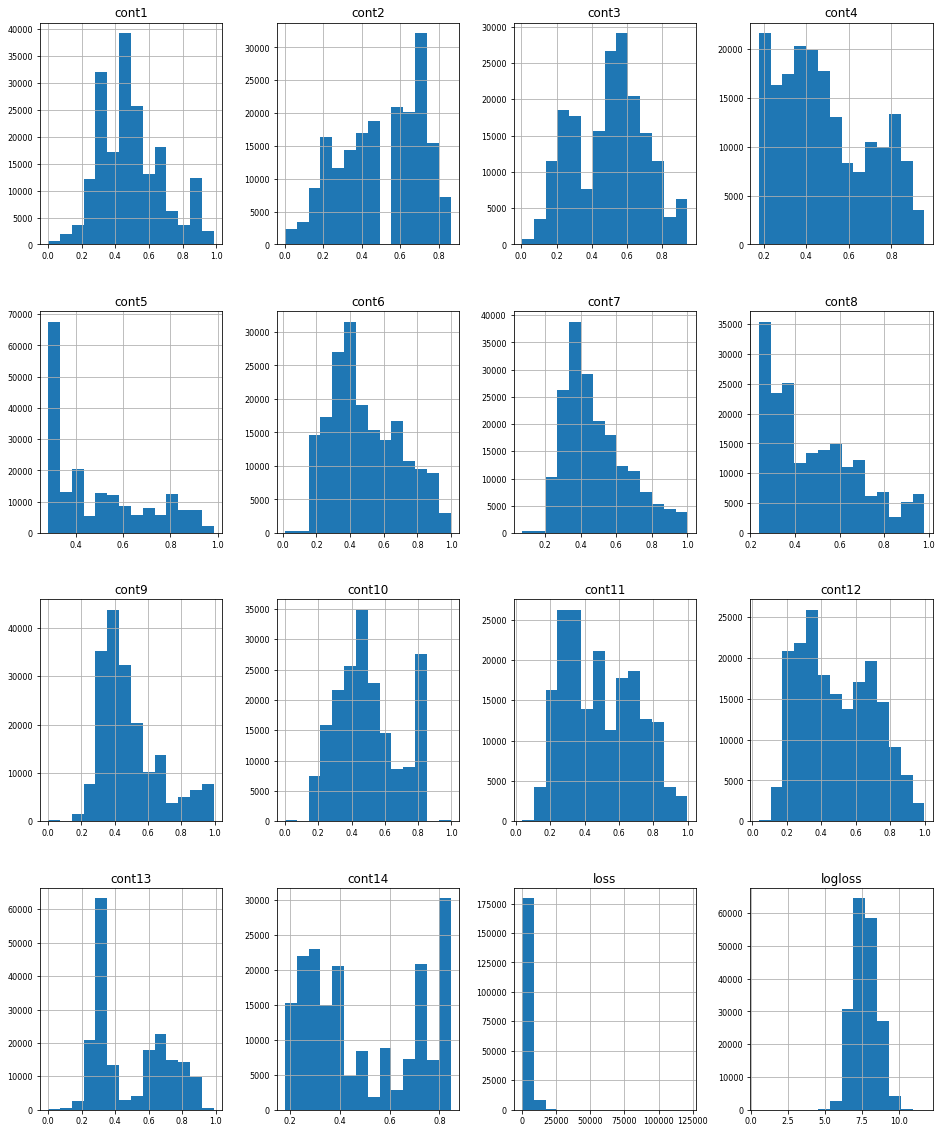

In [12]:
df_num.hist(figsize=(16, 20), bins=14, xlabelsize=8, ylabelsize=8); 

<font color=red> cont6 and cont7 may be related.  cont11 and cont12 may also be related.</font>

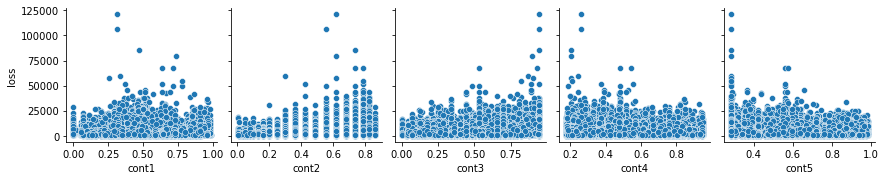

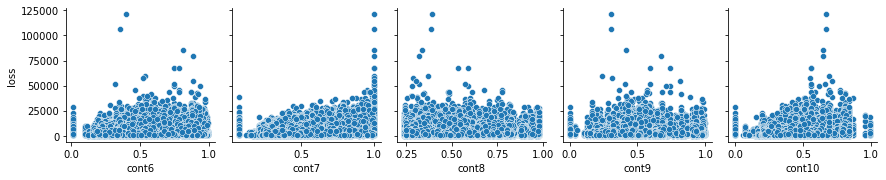

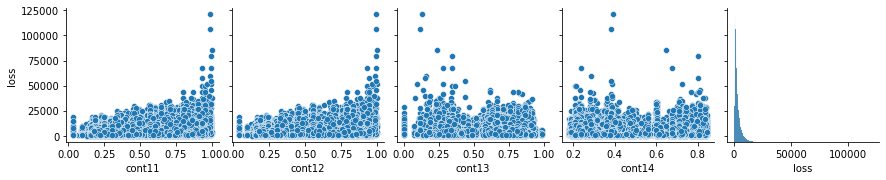

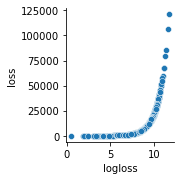

In [13]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['loss'])

<font color=red> loss doesnt look to be significantly correlated with any of these variables.  loss seems to generally increase as cont7, cont11, and cont12 increase but it looks to be only a weak correlation.</font>

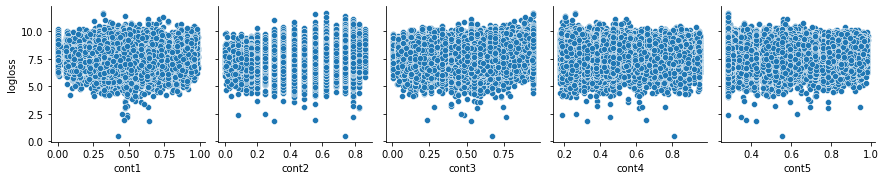

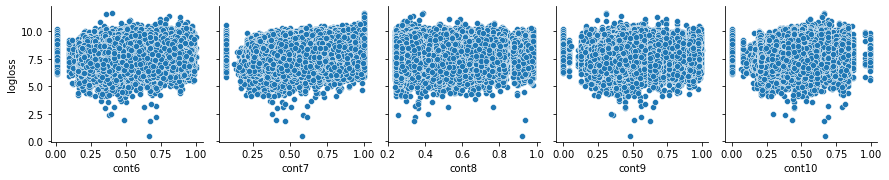

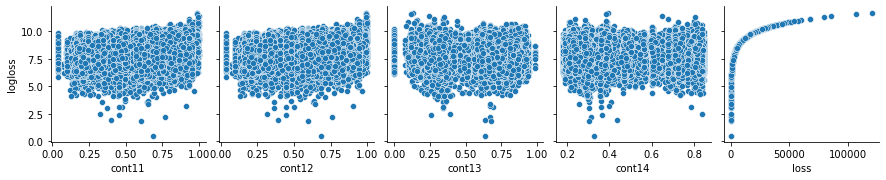

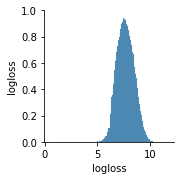

In [14]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['logloss'])

<font color=red> cont3, cont11, and cont12 all appear to be positively correlated with logloss.</font>

Text(0.5, 1.0, 'Numerical Variable Correlations')

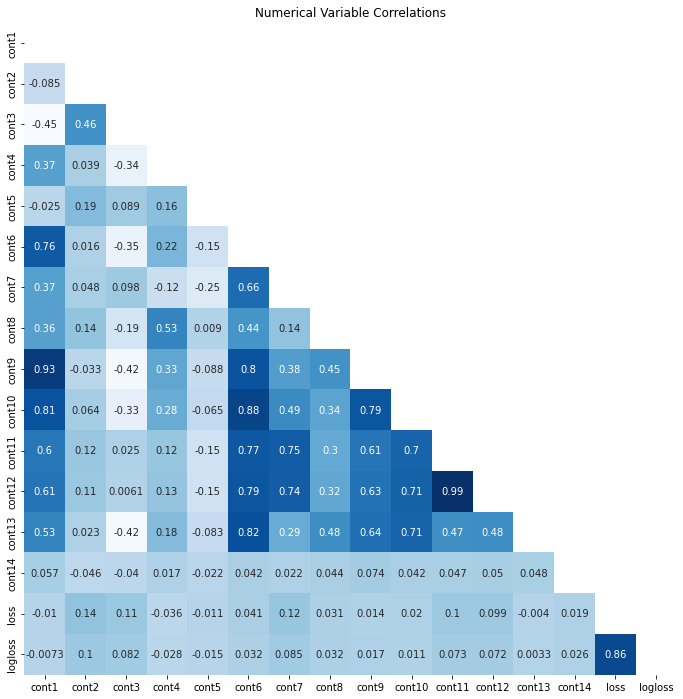

In [15]:
df_num_corr = df_num.corr()
f = plt.subplots(figsize=(12, 12))
mask = np.triu(np.ones_like(df_num_corr, dtype=bool))
sns.heatmap(df_num_corr, cbar=False ,  annot=True, cmap='Blues', mask=mask, square=True).set_title('Numerical Variable Correlations')

<font color=red> no particulary promising trends here.  we observe that some of the indepednent variables are highly correlated but correlation with loss is weak for all variables  </font>

### Categorial Variables

In [16]:
df_obj = df.select_dtypes(include = ['object'])
df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 116 entries, cat1 to cat116
dtypes: object(116)
memory usage: 166.7+ MB


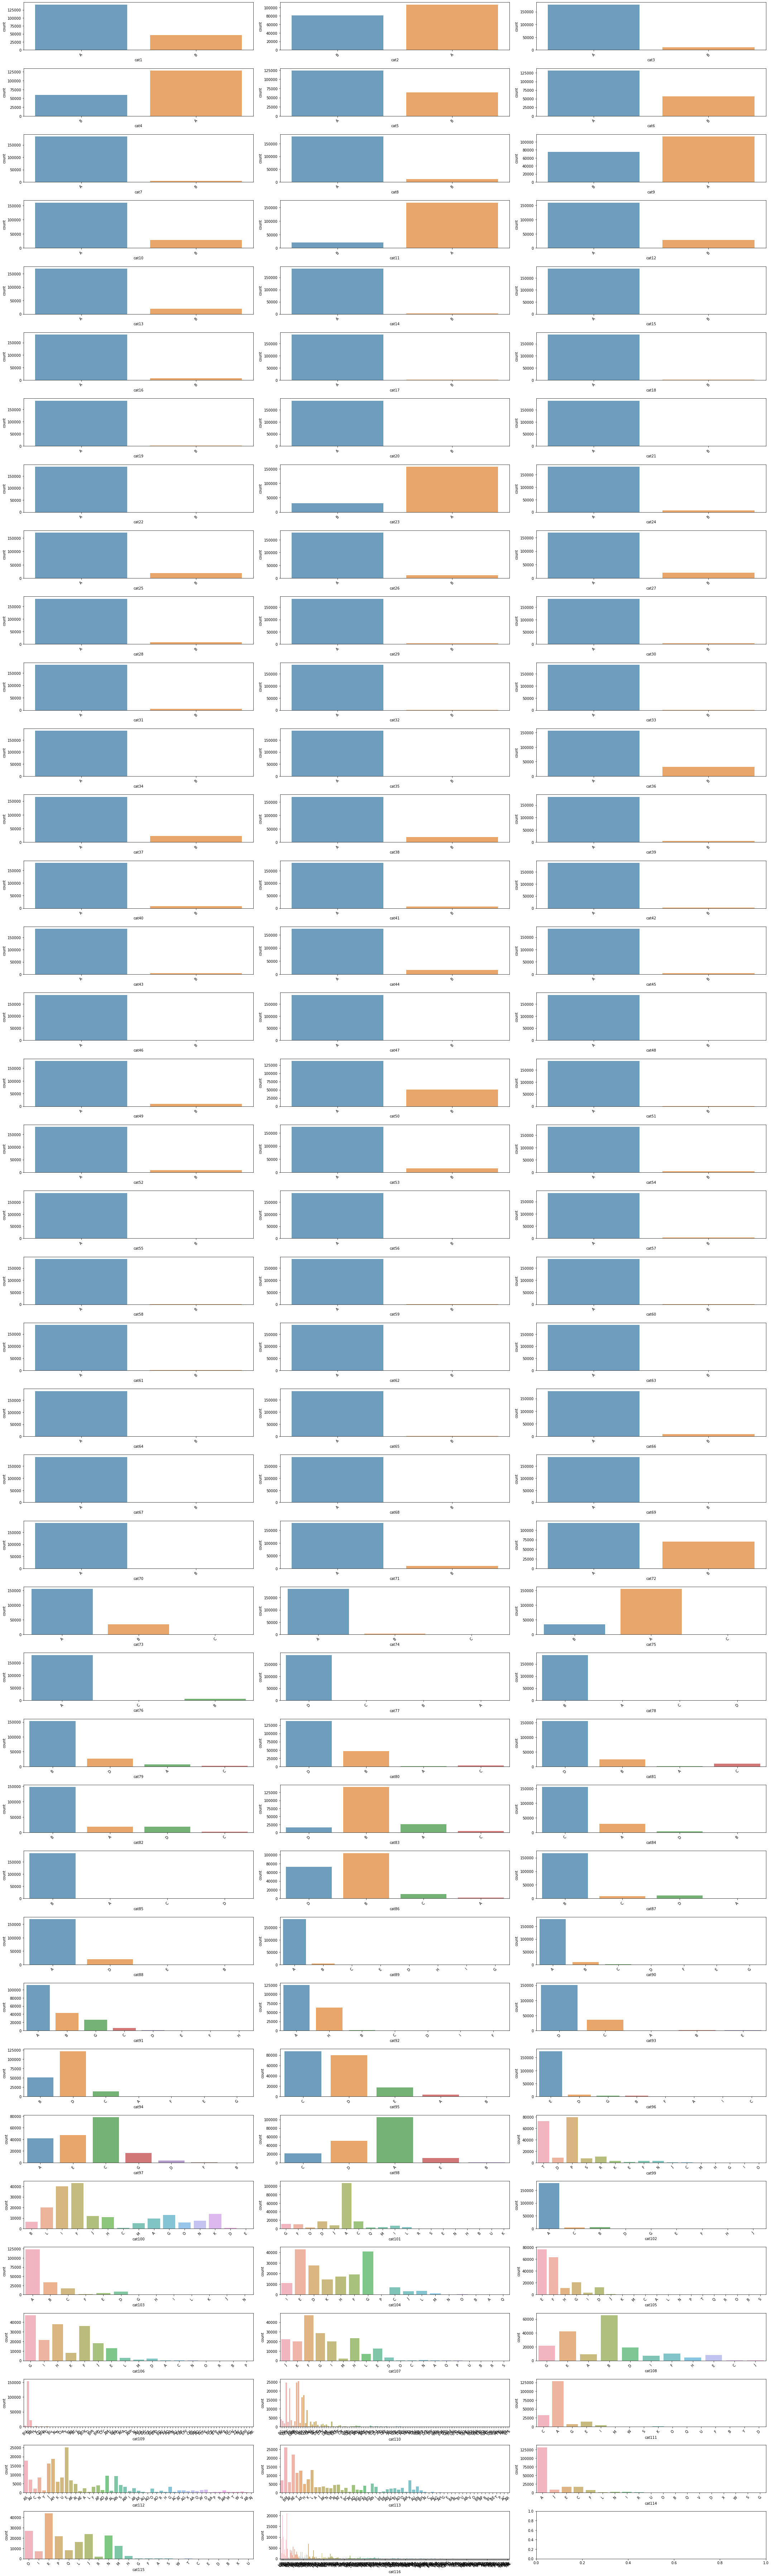

In [17]:
fig, axes = plt.subplots(round(len(df_obj.columns) / 3), 3,figsize = (30, 100))

for i, ax in enumerate(fig.axes):
    if i < len(df_obj.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_obj.columns[i], alpha=0.7, data=df_obj, ax=ax)

fig.tight_layout()

116 categorical values. Many of them have most of their observations in a single level.  these probably arent going to be very helpful for our predictive model, since we want variables that differentiate between large and small losses.  Let's ignore any categorical variable with less than 10% of the data in its smallest level.  this will leave us with variables that hopefully are more useful in our predictive model.

In [18]:
df_obj2 = df_obj[[column for column in df_obj if min(pd.value_counts(df_obj[column])) / len(df_obj) >= 0.10]]
df_obj2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   cat1    188318 non-null  object
 1   cat2    188318 non-null  object
 2   cat4    188318 non-null  object
 3   cat5    188318 non-null  object
 4   cat6    188318 non-null  object
 5   cat9    188318 non-null  object
 6   cat10   188318 non-null  object
 7   cat11   188318 non-null  object
 8   cat12   188318 non-null  object
 9   cat13   188318 non-null  object
 10  cat23   188318 non-null  object
 11  cat27   188318 non-null  object
 12  cat36   188318 non-null  object
 13  cat37   188318 non-null  object
 14  cat38   188318 non-null  object
 15  cat50   188318 non-null  object
 16  cat72   188318 non-null  object
dtypes: object(17)
memory usage: 24.4+ MB


okay with is a much more managable list.  lets look at how these relate to loss

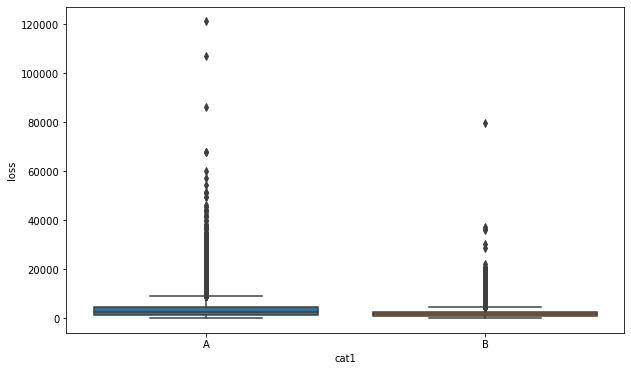

In [19]:
#looking at a boxplot of just cat1 against loss before we dig further
df_obj2['loss'] = df['loss']
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='cat1', y='loss', data=df_obj2)

<font color=red> outliers are making it hard to interpret these visualizations.  so im giong to pivot to dealing with outliers next and then we will pick back up our EDA on these categorical independent variables once we make a decision on outliers </font>

# Outliers

<AxesSubplot:xlabel='loss'>

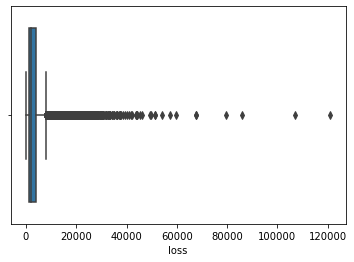

In [20]:
#from our earlier analysis we know this distribution is right-tailed
sns.boxplot(df['loss'])

<font color=red> we observe many outliers</font>

In [21]:
#calculating mild and extreme outliers
mild_outlier = df.loss.quantile(.75) + 1.5 * (df.loss.quantile(.75) - df.loss.quantile(.25))
extreme_outlier = df.loss.quantile(.75) + 3 * (df.loss.quantile(.75) - df.loss.quantile(.25))

In [22]:
df_no_mild = df[df['loss'] <= mild_outlier]
df_no_extreme = df[df['loss'] <= extreme_outlier]

[Text(0.5, 1.0, 'Marg Dist - Drop Extreme Outl')]

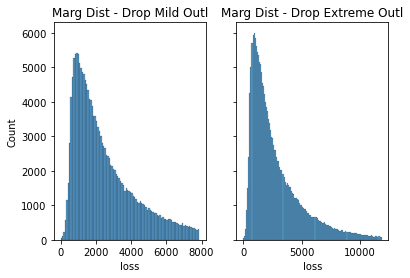

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.histplot(data=df_no_mild.loss,ax=ax1).set(title="Marg Dist - Drop Mild Outl")
sns.histplot(data=df_no_extreme.loss,ax=ax2).set(title="Marg Dist - Drop Extreme Outl")

<font color=red> i will exclude all mild outliers</font>

### Revisiting Categorial Variables now that we have removed outliers

just preparingmy dataset first

In [24]:
#neet to create my categorical dataframe but excluding the mild outliers i decided to drop
df_obj3 = df_no_mild[[column for column in df_obj2]]
df_obj3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176764 entries, 0 to 188317
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat1    176764 non-null  object 
 1   cat2    176764 non-null  object 
 2   cat4    176764 non-null  object 
 3   cat5    176764 non-null  object 
 4   cat6    176764 non-null  object 
 5   cat9    176764 non-null  object 
 6   cat10   176764 non-null  object 
 7   cat11   176764 non-null  object 
 8   cat12   176764 non-null  object 
 9   cat13   176764 non-null  object 
 10  cat23   176764 non-null  object 
 11  cat27   176764 non-null  object 
 12  cat36   176764 non-null  object 
 13  cat37   176764 non-null  object 
 14  cat38   176764 non-null  object 
 15  cat50   176764 non-null  object 
 16  cat72   176764 non-null  object 
 17  loss    176764 non-null  float64
dtypes: float64(1), object(17)
memory usage: 25.6+ MB


<font color ='red'> looking at boxplot of these categorical variables against loss </font>

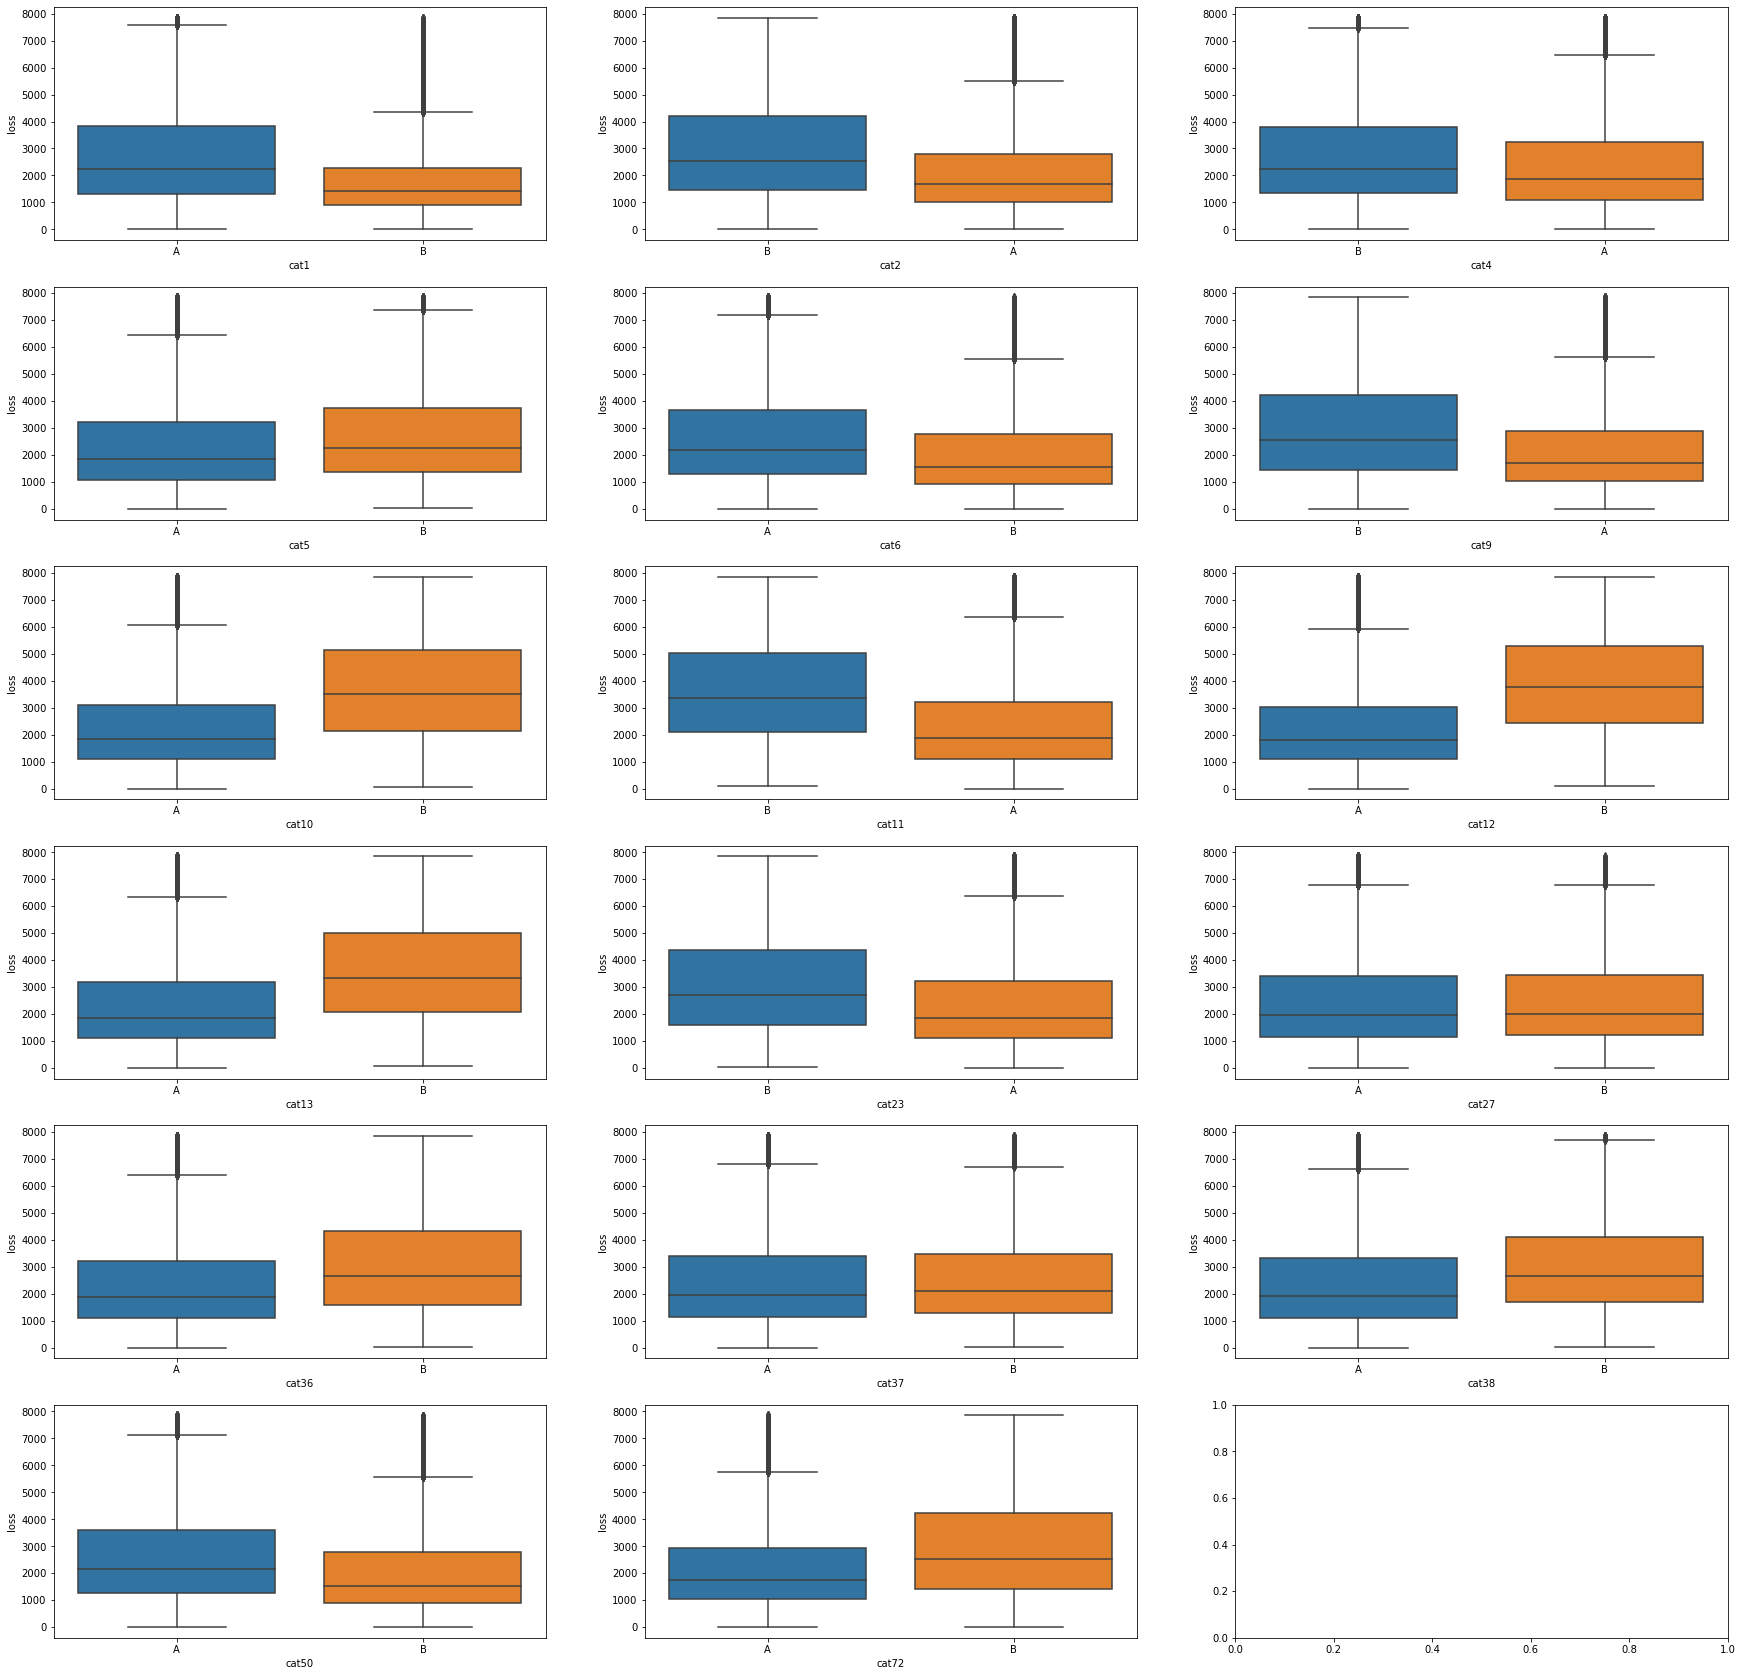

In [25]:
col_list = df_obj3.columns.tolist()
col_list = col_list[:-1]
fig, axes = plt.subplots(round(len(df_obj3.columns) / 3), 3,figsize = (30, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_obj3.columns) - 1:
        sns.boxplot(x=col_list[i], y='loss', data=df_obj3, ax=ax)

<font color=red> 
CAT 10, 12, and 13 look the most promising.  they have the modest distinction between loss size when comparing the two levels.  although it does look like all 3 independent variables might be related to each other

cat 11 also looks promising

</font>

### Variable Creation/Tranformation

<font color='red'> lets first focus on possible combinations of 10, 12, 13.  as we thought these variables had significant simalarities </font>

<AxesSubplot:xlabel='cat10/12/13', ylabel='loss'>

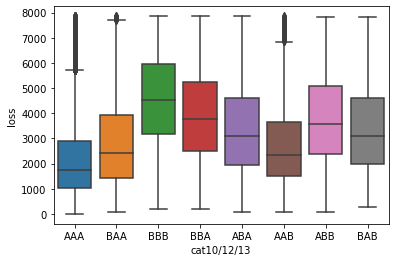

In [26]:
df_no_mild['cat10/12/13'] = df_no_mild['cat10'] + df_no_mild['cat12'] + df_no_mild['cat13'] 
sns.boxplot(x='cat10/12/13', y='loss', data=df_no_mild)

In [27]:
df_no_mild['cat10/12/13'].value_counts(normalize='True')

AAA    0.778829
BBA    0.048879
BAA    0.041417
ABA    0.038882
AAB    0.034979
BBB    0.031483
ABB    0.014522
BAB    0.011009
Name: cat10/12/13, dtype: float64

<font color='red'>CAT 10, 12, and 13 do overlap quite a bit in the AAA bucket but there is decent volume spread across the other levels </font>

<font color=red> 
the levels of the combined 10+12+13 variable does seem to correlate with different loss amounts.  we will keep this variable as it may have promise predicting claims size

</font>

We didnt have much luck with the numerical independent variables.  Let's try converting some of these into descrete variables and seeeing if we have any better luck with that.

In [28]:
#preparing a df of continuous variables that we will convert to discrete variables
df_prep = df_no_mild
df_prep = df_prep.select_dtypes(include = ['float64'])
df_prep = df_prep.drop(columns='loss')
df_prep.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,logloss
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,7.702637
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,7.158203
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,8.008396
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,6.846784
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,7.924742


In [29]:
for column in df_prep.columns:
    df_prep[column] = pd.cut(df_prep[column], bins=4, labels=np.arange(4),right=False)
df_prep['loss'] = df_no_mild['loss']
df_prep.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,logloss,loss
0,2,1,0,3,0,2,1,0,2,3,2,2,3,3,3,2213.18
1,1,3,2,2,3,1,1,1,1,1,1,1,2,0,3,1283.60
2,1,1,2,0,0,1,1,0,1,1,1,1,0,3,3,3005.09
3,1,2,2,1,0,1,1,0,1,1,1,1,2,2,2,939.85
4,1,0,2,1,2,0,0,0,0,0,0,0,0,1,3,2763.85


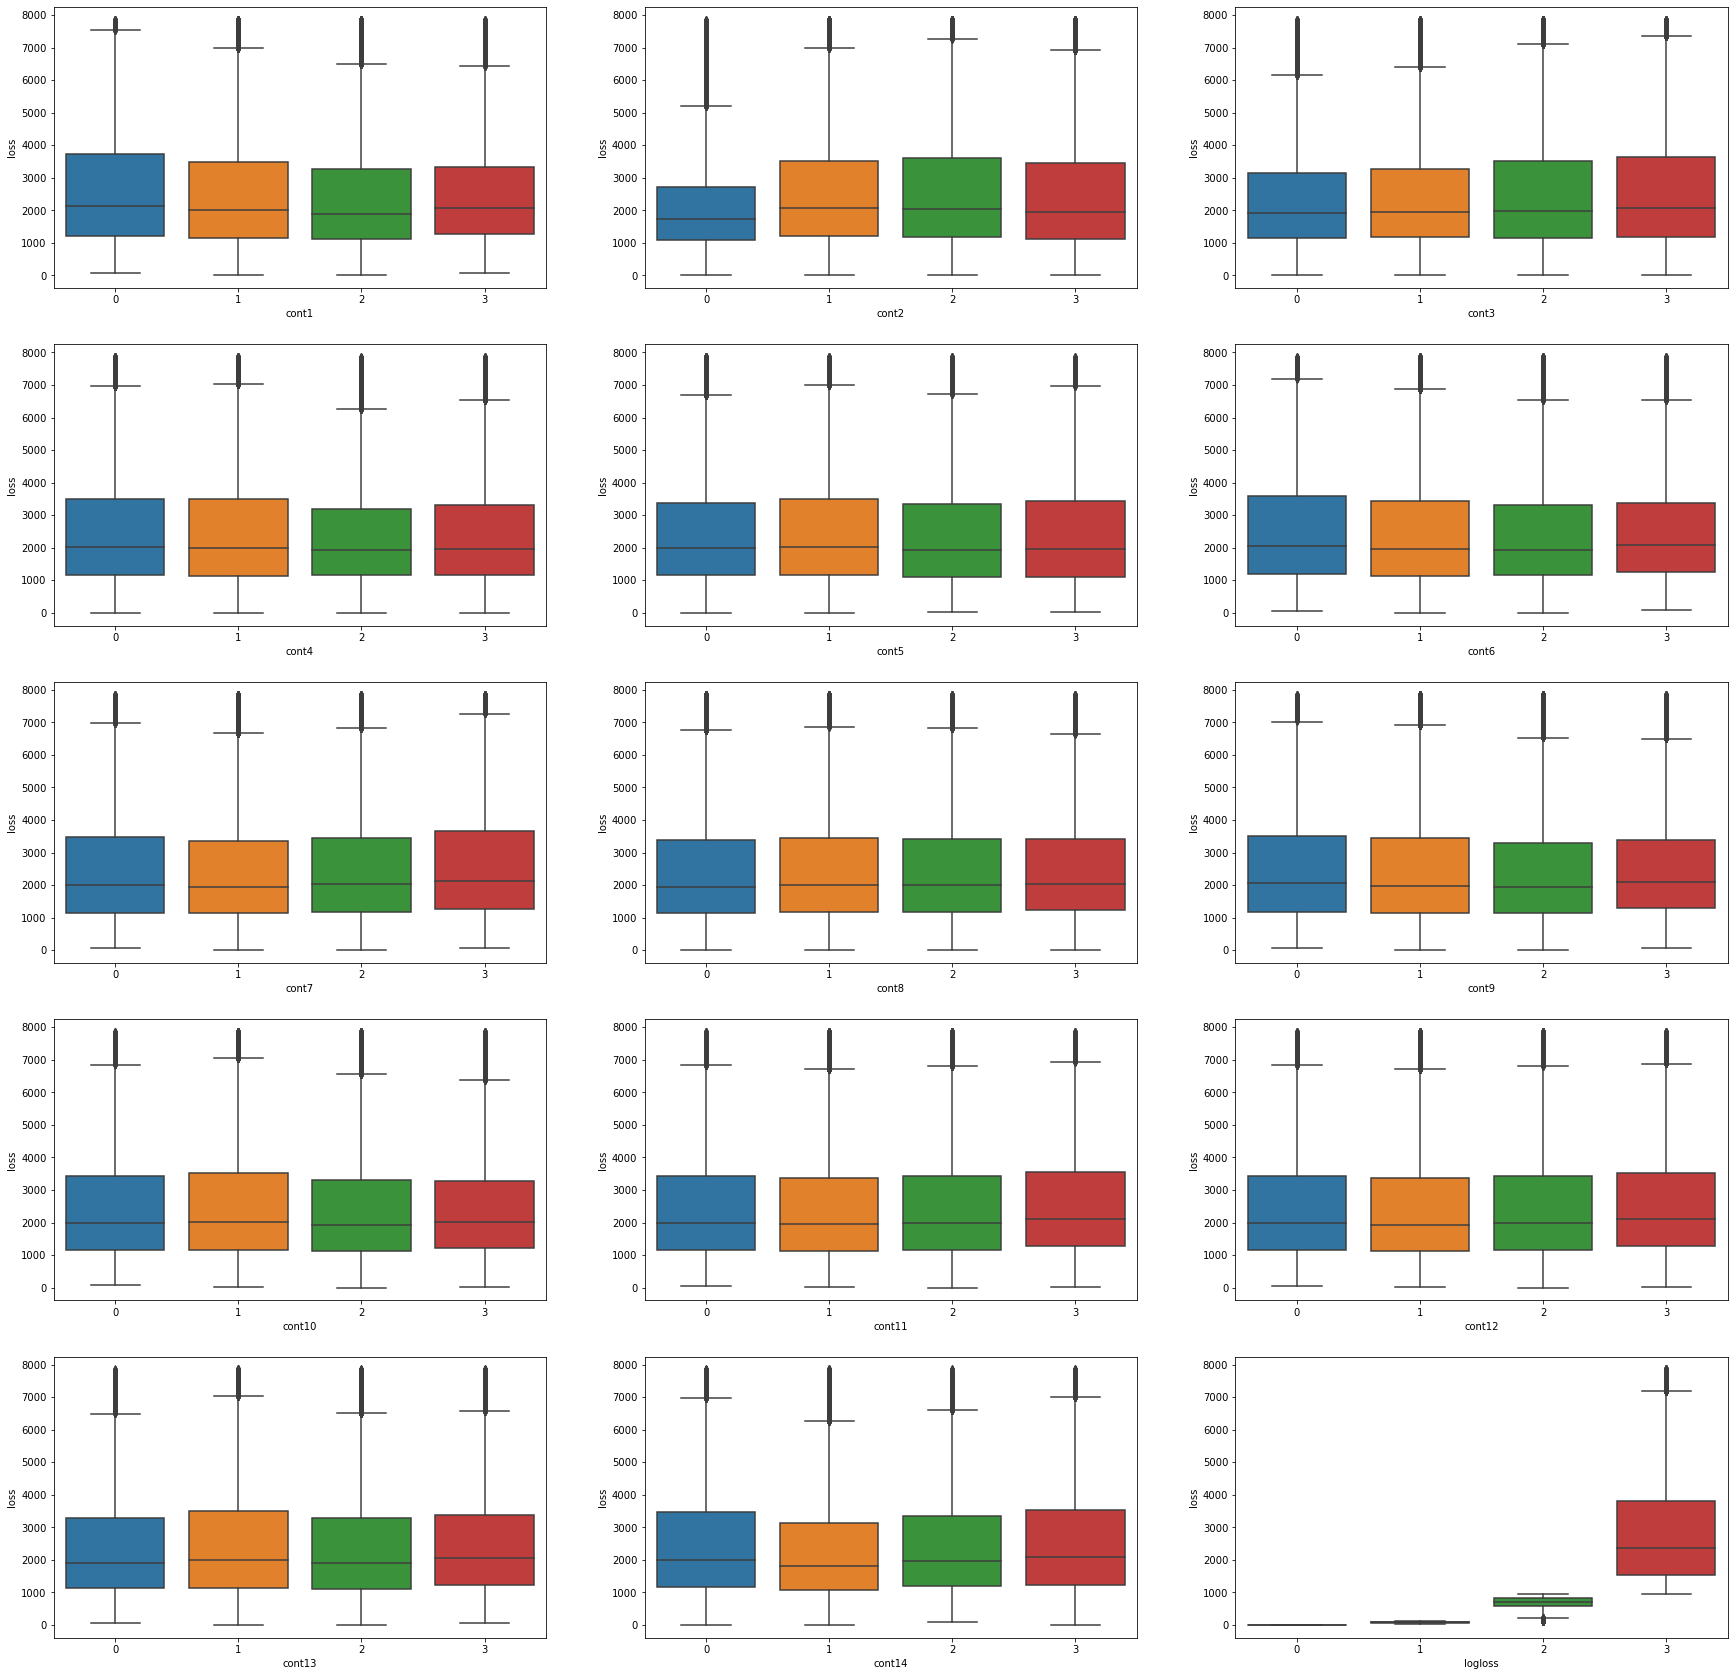

In [30]:
col_list = df_prep.columns.tolist()
col_list = col_list[:-1]
fig, axes = plt.subplots(round(len(df_prep.columns) / 3), 3,figsize = (30, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_prep.columns) - 1:
        sns.boxplot(x=col_list[i], y='loss', data=df_prep, ax=ax)

<font color=red> 
not very promising.  still a lot of overlap of loss size between layers

</font>

### Min/Max Scaling Dataset

In [31]:
#min maxing all numerical variables
df_min_max = df.select_dtypes(include = ['float64'])
col_list = df_min_max.columns
scaler = MinMaxScaler()
model=scaler.fit(df_min_max)
df_min_max=model.transform(df_min_max)
df_min_max = pd.DataFrame(df_min_max,columns=col_list)
df_min_max.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,logloss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.501387,0.587390,0.527056,0.405069,0.293631,0.485802,0.446500,0.335733,0.487709,0.500579,0.475586,0.474843,0.498762,0.475090,0.025094,0.640979
std,0.190506,0.240511,0.214636,0.271802,0.297534,0.208509,0.191779,0.268216,0.182514,0.186815,0.217700,0.217642,0.215304,0.334504,0.023998,0.072498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.351359,0.414588,0.355058,0.193514,0.000000,0.328521,0.301637,0.102136,0.360578,0.366419,0.286105,0.286234,0.319276,0.172731,0.009948,0.588142
50%,0.483033,0.643795,0.557931,0.354997,0.200881,0.435014,0.396328,0.274687,0.443445,0.463517,0.437900,0.442768,0.367633,0.342313,0.017477,0.638445
75%,0.633423,0.790027,0.670750,0.611224,0.515525,0.652465,0.560498,0.520234,0.569405,0.617691,0.668039,0.664615,0.697936,0.819245,0.031926,0.692255
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Standard Scaling

In [32]:
#standard_scaling all numerical variables
df_standard = df.select_dtypes(include = ['float64'])
col_list = df_standard.columns
scaler = StandardScaler()
model2=scaler.fit(df_standard)
df_standard=model2.transform(df_standard)
df_standard = pd.DataFrame(df_standard,columns=col_list)
df_standard.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,logloss
count,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05,1.883180e+05
mean,-4.205663e-16,-3.608128e-16,1.059941e-16,7.629480e-16,-1.125268e-15,7.563180e-17,-1.147815e-16,1.031332e-15,-7.410699e-16,9.194810e-17,7.038530e-16,-7.318259e-16,-1.082716e-15,-2.982660e-16,1.463992e-16,2.716179e-15
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.631881e+00,-2.442261e+00,-2.455589e+00,-1.490316e+00,-9.868842e-01,-2.329891e+00,-2.328204e+00,-1.251730e+00,-2.672174e+00,-2.679556e+00,-2.184604e+00,-2.181765e+00,-2.316558e+00,-1.420286e+00,-1.045656e+00,-8.841390e+00
25%,-7.875273e-01,-7.184773e-01,-8.013468e-01,-7.783474e-01,-9.868842e-01,-7.543139e-01,-7.553681e-01,-8.709303e-01,-6.965570e-01,-7.181437e-01,-8.703801e-01,-8.666038e-01,-8.336422e-01,-9.039048e-01,-6.311392e-01,-7.288127e-01
50%,-9.634084e-02,2.345240e-01,1.438494e-01,-1.842255e-01,-3.117298e-01,-2.435770e-01,-2.616155e-01,-2.276036e-01,-2.425212e-01,-1.983893e-01,-1.731129e-01,-1.473762e-01,-6.090452e-01,-3.969402e-01,-3.174045e-01,-3.495024e-02
75%,6.930871e-01,8.425272e-01,6.694845e-01,7.584762e-01,7.457784e-01,7.993124e-01,5.944241e-01,6.878805e-01,4.476154e-01,6.268911e-01,8.840306e-01,8.719477e-01,9.250844e-01,1.028851e+00,2.846711e-01,7.072796e-01
max,2.617323e+00,1.715558e+00,2.203481e+00,2.188845e+00,2.374086e+00,2.466081e+00,2.886134e+00,2.476616e+00,2.806862e+00,2.673360e+00,2.408891e+00,2.412945e+00,2.328058e+00,1.569220e+00,4.062387e+01,4.952190e+00


<a id='week2'></a>
# Week 2 - Regression

### Feature Creation

In [33]:
#read in test data
df_test = pd.read_csv("test.csv")
print(df_test.shape)
print(df.shape)

(125546, 131)
(188318, 133)


In [34]:
print(df_test.shape)
print(df.shape)
df['cat10/12/13'] = df['cat10'] + df['cat12'] + df['cat13'] 
df_test['cat10/12/13'] = df_test['cat10'] + df_test['cat12'] + df_test['cat13'] 
droplist = ['cat10','cat12','cat13']
df = df.drop(columns=droplist)
df_test = df_test.drop(columns=droplist)
print(df_test.shape)
print(df.shape)

(125546, 131)
(188318, 133)
(125546, 129)
(188318, 131)


### Setup Indicator Variables

In [35]:
#going to merge testing and training data temporary to create the dummy variables
#either file may have levels that appear in one file but not the other
#merging now and doing the dummy variables on the combined data ensures i get consistent dummy variables between both
#and then i will immediately seperate them again

In [36]:
#saving test ids and removing unneeded columns
ids = df_test['id']
drop_feature_1 = ['id']
drop_feature_2 = ['id','loss','logloss']
df_test = df_test.drop(columns=drop_feature_1)
df_train = df.drop(columns=drop_feature_2)
print(df_test.shape)
print(df_train.shape)

(125546, 128)
(188318, 128)


In [37]:
#merginging data frames together
df_test['source'] = 'Test'
df_train['source'] = 'Train'
df_combined = pd.concat([df_test, df_train], ignore_index=True, axis=0)
df_combined.shape

(313864, 129)

In [38]:
#creating dummy variables
df_combined2 = pd.get_dummies(data=df_combined, drop_first=True)
df_combined2.shape

(313864, 1079)

In [39]:
#splitting databases
df_test_2 = df_combined2[df_combined2['source_Train'] == 0]
df_train_2 = df_combined2[df_combined2['source_Train'] == 1]
drop_list = ['source_Train']
df_test_2 = df_test_2.drop(columns = drop_list)
df_train_2 = df_train_2.drop(columns = drop_list)
print(df_test_2.shape)
print(df_train_2.shape)

(125546, 1078)
(188318, 1078)


### Adding Constant for Modeling

In [40]:
#add constant varaible to test data
df_test_2 = sm.add_constant(df_test_2)
df_train_2 = sm.add_constant(df_train_2)
print(df_test_2.shape)
print(df_train_2.shape)

(125546, 1079)
(188318, 1079)


<a id='holdout'></a>
### Setup Cross Validation DataFrames

In [41]:
y = df['logloss']
X= df_train_2
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(188318, 1079)
(112990, 1079)
(75328, 1079)
(112990,)
(75328,)


In [42]:
#resetting indices
X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()
drop_list = ['index']
X_train = X_train.drop(columns = drop_list)
X_test = X_test.drop(columns = drop_list)
y_train = y_train.drop(columns = drop_list)
y_test = y_test.drop(columns = drop_list)

<a id='lin_model'></a>
### Linear Regression (All Variables)

<font color=red> 
Running a linear regression on all independent variables to predicted logloss
</font>

In [43]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112990, 1079)
(75328, 1079)
(112990, 1)
(75328, 1)


In [44]:
lin_model = sm.OLS(y_train, X_train).fit()
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logloss   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     131.2
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:57:05   Log-Likelihood:                -94812.
No. Observations:              112990   AIC:                         1.915e+05
Df Residuals:                  112045   BIC:                         2.006e+05
Df Model:                         944                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.8437      0.351     13.815      0.000       4.156       5.531
cont1              -0.1244      0.076     -1.645      0.100      -0.273       0.024
cont2               0.2497      0.018     13.831      0.000       0.214       0.285
cont3               0.2582      0.053      4.858      0.000       0.154       0.362
cont4               0.0274      0.048      0.576      0.565      -0.066       0.121
cont5              -0.0217      0.015     -1.475      0.140      -0.051       0.007
cont6               0.1745      0.090      1.940      0.052      -0.002       0.351
cont7               0.1032      0.041      2.506      0.012       0.023       0.184
cont8               0.0600      0.022      2.764      0.006       0.017       0.103
cont9               0.1046      0.055      1.918      0.055      -0.002       0.211
cont10             -0.0281      0.067     -0.418      0.676      -0.160       0.104
cont11             -0.1693      0.102     -1.667      0.096      -0.368       0.030
cont12             -0.1055      0.130     -0.813      0.416      -0.360       0.149
cont13              0.2786      0.140      1.992      0.046       0.005       0.553
cont14              0.0255      0.046      0.553      0.581      -0.065       0.116
cat1_B             -0.0937      0.005    -20.131      0.000      -0.103      -0.085
cat2_B              0.1831      0.090      2.029      0.042       0.006       0.360
cat3_B              0.0008      0.054      0.016      0.988      -0.104       0.106
cat4_B              0.0757      0.121      0.623      0.533      -0.162       0.314
cat5_B              0.2408      0.074      3.272      0.001       0.097       0.385
cat6_B              0.2379      0.464      0.513      0.608      -0.671       1.147
cat7_B              0.0757      0.079      0.959      0.337      -0.079       0.230
cat8_B             -0.0545      0.095     -0.572      0.567      -0.241       0.132
cat9_B             -0.0083      0.029     -0.290      0.771      -0.064       0.048
cat11_B             0.0832      0.028      2.996      0.003       0.029       0.138
cat14_B            -0.1048      0.048     -2.201      0.028      -0.198      -0.011
cat15_B             0.0052      0.126      0.041      0.967      -0.243       0.253
cat16_B            -0.0275      0.044     -0.619      0.536      -0.115       0.060
cat17_B            -0.0214      0.047     -0.458      0.647      -0.113       0.070
cat18_B            -0.0294      0.047     -0.618      0.536      -0.122       0.064
cat19_B             0.0728      0.046      1.576      0.115      -0.018       0.163
cat20_B            -0.0326      0.063     -0.519      0.604      -0.155       0.090
cat21_B            -0.1367      0.054     -2.511      0.012      -0.243      -0.030
cat22_B            -0.2915      0.112     -2.612      0.009

<font color=red> 
We observe a number of the variables have large p-values, implying they are not adding much to the model.  It is worthwhile to invest some time trying to weed out the irrelevant independent variables
</font>

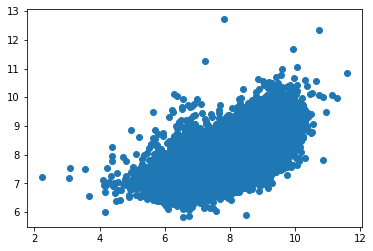

In [45]:
lin_predict = lin_model.predict(X_test)
plt.scatter(y_test, lin_predict)

In [46]:
mse_test = metrics.mean_squared_error(y_test, lin_predict)
print(f"mse test: {np.sqrt(mse_test)}")


mse test: 0.5648453851952754


### Linear Regression - Backward Selection

In [47]:
#setup some script to do the backward selection
#starting with all variables and going to remove all variables that have p value less than 5%
def backward_reg_first_pass(model_in):
    p_values = model_in.summary2().tables[1]
    p_values.reset_index(inplace=True)
    p_values = p_values.rename(columns={'P>|t|': 'p','index':'var'})
    df_sig = p_values[p_values['p']<.05]

    keep_list = df_sig['var'].tolist()
    keep_list.remove('const')

    X = X_train[keep_list]
    Xc = sm.add_constant(X)
    y = y_train

    model_out = sm.OLS(y, Xc).fit()
    return keep_list

def backward_reg_list_logic(list_in):
    X = X_train[list_in]
    Xc = sm.add_constant(X)
    y = y_train

    model_out = sm.OLS(y, Xc).fit()
    
    p_values = model_out.summary2().tables[1]
    p_values.reset_index(inplace=True)
    p_values = p_values.rename(columns={'P>|t|': 'p','index':'var'})
    df_sig = p_values[p_values['p']<.05]

    keep_list = df_sig['var'].tolist()
    keep_list.remove('const')
    
    return keep_list

In [48]:
#iterating through until the backward selection stabilizes
seed = backward_reg_first_pass(lin_model)
count_start = 0
count_end = 10
while count_start != count_end:
    count_start = len(seed)
    seed = backward_reg_list_logic(seed)
    count_end = len(seed)

In [49]:
#left with this many variables
len(seed)

222

In [50]:
seed

['cont2',
 'cont3',
 'cont7',
 'cont8',
 'cont13',
 'cat1_B',
 'cat2_B',
 'cat5_B',
 'cat11_B',
 'cat14_B',
 'cat21_B',
 'cat22_B',
 'cat23_B',
 'cat25_B',
 'cat26_B',
 'cat27_B',
 'cat29_B',
 'cat31_B',
 'cat32_B',
 'cat33_B',
 'cat35_B',
 'cat37_B',
 'cat38_B',
 'cat39_B',
 'cat41_B',
 'cat42_B',
 'cat44_B',
 'cat48_B',
 'cat57_B',
 'cat59_B',
 'cat63_B',
 'cat67_B',
 'cat72_B',
 'cat73_B',
 'cat73_C',
 'cat74_B',
 'cat74_C',
 'cat75_B',
 'cat76_B',
 'cat77_B',
 'cat79_B',
 'cat79_C',
 'cat79_D',
 'cat80_B',
 'cat80_C',
 'cat82_D',
 'cat83_C',
 'cat83_D',
 'cat84_C',
 'cat86_B',
 'cat90_B',
 'cat90_C',
 'cat91_C',
 'cat91_D',
 'cat91_E',
 'cat91_F',
 'cat91_H',
 'cat92_I',
 'cat93_B',
 'cat93_C',
 'cat93_D',
 'cat93_E',
 'cat94_B',
 'cat94_C',
 'cat94_D',
 'cat95_B',
 'cat95_C',
 'cat95_D',
 'cat95_E',
 'cat97_C',
 'cat97_E',
 'cat99_D',
 'cat99_E',
 'cat99_F',
 'cat99_K',
 'cat99_N',
 'cat99_S',
 'cat100_B',
 'cat100_C',
 'cat100_D',
 'cat100_E',
 'cat100_F',
 'cat100_G',
 'cat100_H

<font color=red> 
Categorical variables with more than 2 levels created 3+ seperate variables in the regression.  
We eliminated any individual varaible that with p<5% in our backward selection.
That may have created a situations where the some of the levels from the original categorical variable were eliminated from the model
and others were not.  We don't want to level in partial levels, so I manually eliminate any categorical variable where only partial levels survived the backward selection
</font>

In [51]:
remove_list = [ 'cat116_X', 'cat116_V', 'cat116_Q', 'cat116_P', 'cat116_MN', 'cat116_LW', 'cat116_JY', 'cat116_JP', 'cat116_JK', 'cat116_HV', 'cat116_HQ', 'cat116_HP', 'cat116_HL', 'cat116_HK', 'cat116_HH', 'cat116_HG', 'cat116_HA', 'cat116_GS', 'cat116_GK', 'cat116_GG', 'cat116_FU', 'cat116_FK', 'cat116_FG', 'cat116_CV', 'cat116_CO', 'cat116_CM', 'cat116_CH', 'cat116_BF', 'cat116_BC', 'cat115_E', 'cat115_C', 'cat115_B', 'cat113_Y', 'cat113_X', 'cat113_S', 'cat113_Q', 'cat113_M', 'cat113_L', 'cat113_K', 'cat113_H', 'cat113_G', 'cat113_F', 'cat113_BH', 'cat113_BE', 'cat113_AY', 'cat113_AX', 'cat113_AV', 'cat113_AQ', 'cat113_AP', 'cat113_AG', 'cat112_V', 'cat112_U', 'cat112_S', 'cat112_N', 'cat112_L', 'cat112_K', 'cat112_J', 'cat112_I', 'cat112_G', 'cat112_E', 'cat112_C', 'cat112_B', 'cat112_AY', 'cat112_AW', 'cat112_AV', 'cat112_AT', 'cat112_AS', 'cat112_AP', 'cat112_AO', 'cat112_AN', 'cat112_AL', 'cat112_AJ', 'cat112_AI', 'cat112_AH', 'cat112_AF', 'cat112_AE', 'cat112_AD', 'cat112_AB', 'cat110_T', 'cat110_Q', 'cat110_O', 'cat110_N', 'cat110_EL', 'cat110_EG', 'cat110_DO', 'cat110_DM', 'cat110_DL', 'cat110_DI', 'cat110_CS', 'cat110_CR', 'cat110_CQ', 'cat110_CO', 'cat110_CM', 'cat110_CL', 'cat110_CK', 'cat110_CI', 'cat110_BX', 'cat110_BT', 'cat110_BR', 'cat110_BP', 'cat110_BE', 'cat110_BC', 'cat110_AW', 'cat110_AR', 'cat110_AM', 'cat108_K', 'cat108_H', 'cat108_E', 'cat107_B', 'cat105_P', 'cat105_N', 'cat104_P', 'cat104_O', 'cat104_M', 'cat104_L', 'cat104_K', 'cat104_J', 'cat104_G', 'cat103_G', 'cat103_F', 'cat103_E', 'cat103_D', 'cat103_B', 'cat102_F', 'cat101_J', 'cat100_O', 'cat100_N', 'cat100_M', 'cat100_L', 'cat100_K', 'cat100_J', 'cat100_H', 'cat100_G', 'cat100_F', 'cat100_E', 'cat100_D', 'cat100_C', 'cat100_B', 'cat99_S', 'cat99_N', 'cat99_K', 'cat99_F', 'cat99_E', 'cat99_D', 'cat97_E', 'cat97_C', 'cat94_D', 'cat94_C', 'cat94_B', 'cat92_I', 'cat91_H', 'cat91_F', 'cat91_E', 'cat91_D', 'cat91_C', 'cat90_C', 'cat90_B', 'cat86_B', 'cat84_C', 'cat83_D', 'cat83_C', 'cat82_D', 'cat80_C', 'cat80_B', 'cat77_B', 'cat76_B', 'cat75_B']
for i in range(len(remove_list)):
   seed.remove(remove_list[i])

In [52]:
len(seed)

55

<a id='reduced_lin_model'></a>
### Linear Regression - After Backward Selection

In [53]:
X = X_train[seed]
Xc = sm.add_constant(X)
y = y_train

reduced_lin_model = sm.OLS(y, Xc).fit()
reduced_lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logloss   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     1432.
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:57:44   Log-Likelihood:            -1.0741e+05
No. Observations:              112990   AIC:                         2.149e+05
Df Residuals:                  112935   BIC:                         2.155e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.3447      0.043    146.031      0.000       6.260       6.430
cont2               0.3105      0.011     28.856      0.000       0.289       0.332
cont3               0.1536      0.012     12.329      0.000       0.129       0.178
cont7               0.5517      0.012     46.591      0.000       0.528       0.575
cont8               0.0481      0.011      4.396      0.000       0.027       0.069
cont13             -0.0912      0.016     -5.685      0.000      -0.123      -0.060
cat1_B             -0.2324      0.005    -49.639      0.000      -0.242      -0.223
cat2_B              0.1411      0.005     26.196      0.000       0.130       0.152
cat5_B              0.1066      0.006     18.613      0.000       0.095       0.118
cat11_B             0.1233      0.008     16.344      0.000       0.108       0.138
cat14_B             0.1067      0.018      6.050      0.000       0.072       0.141
cat21_B             0.0850      0.040      2.131      0.033       0.007       0.163
cat22_B            -0.2231      0.125     -1.779      0.075      -0.469       0.023
cat23_B             0.1381      0.006     22.980      0.000       0.126       0.150
cat25_B             0.2416      0.008     31.109      0.000       0.226       0.257
cat26_B             0.2277      0.009     24.417      0.000       0.209       0.246
cat27_B             0.2033      0.007     29.646      0.000       0.190       0.217
cat29_B             0.2494      0.014     17.885      0.000       0.222       0.277
cat31_B            -0.0690      0.012     -5.687      0.000      -0.093      -0.045
cat32_B             0.3055      0.024     12.876      0.000       0.259       0.352
cat33_B             0.1199      0.026      4.532      0.000       0.068       0.172
cat35_B             0.2043      0.056      3.659      0.000       0.095       0.314
cat37_B             0.1428      0.007     19.505      0.000       0.128       0.157
cat38_B             0.2305      0.008     29.791      0.000       0.215       0.246
cat39_B            -0.0446      0.012     -3.585      0.000      -0.069      -0.020
cat41_B             0.0898      0.010      8.606      0.000       0.069       0.110
cat42_B             0.2805      0.020     13.843      0.000       0.241       0.320
cat44_B             0.2573      0.008     30.793      0.000       0.241       0.274
cat48_B             0.2246      0.050      4.535      0.000       0.128       0.322
cat57_B             0.6262      0.015     40.835      0.000       0.596       0.656
cat59_B             0.3436      0.046      7.486      0.000       0.254       0.434
cat63_B            -0.1726      0.093     -1.864      0.062      -0.354       0.009
cat67_B             0.2106      0.031      6.823      0.000       0.150       0.271
cat72_B             0.1460      0.004     35.839      0.000

<font color=red> 
We have eliminated a ton of attributes.  And most are now significant (low p-value).  We thought this might have helped avoid overfitting, but the adjusted R squared on this model is lower...so this might have not worked.  Lets check our MSE on the holdout data.
</font>

In [54]:
#parse down x_test to only the variables we retained.
col = [col for col in Xc.columns]
reduced_X_test = X_test[col]
reduced_X_test.shape

(75328, 56)

In [55]:
reduced_lin_predict = reduced_lin_model.predict(reduced_X_test)
mse_test = metrics.mean_squared_error(y_test, reduced_lin_predict)
print(f"mse test: {np.sqrt(mse_test)}")

mse test: 0.6259212068202445


<font color=red> 
Our MSE is worse than our intial regression model
</font>

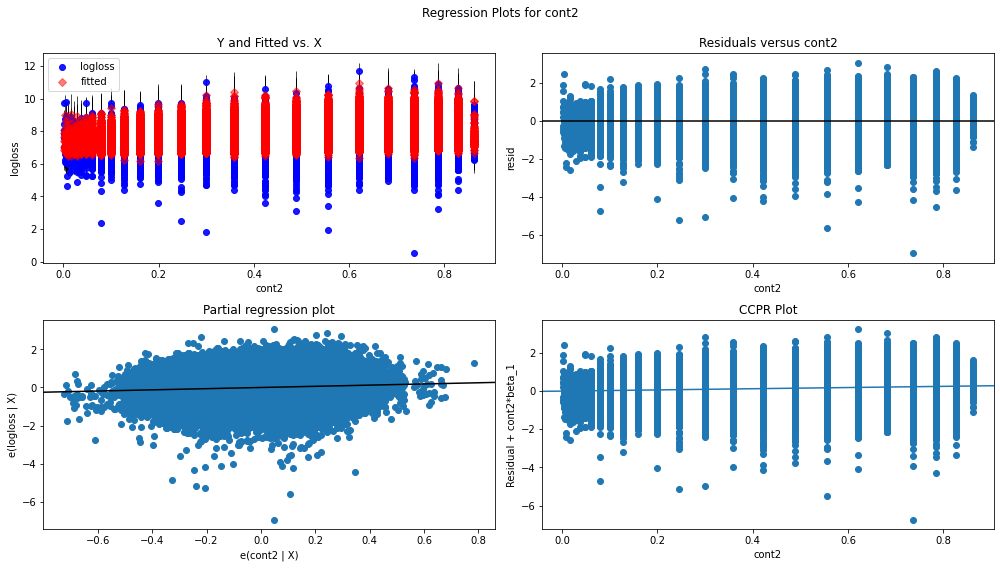

In [56]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(reduced_lin_model, 'cont2', fig=fig)

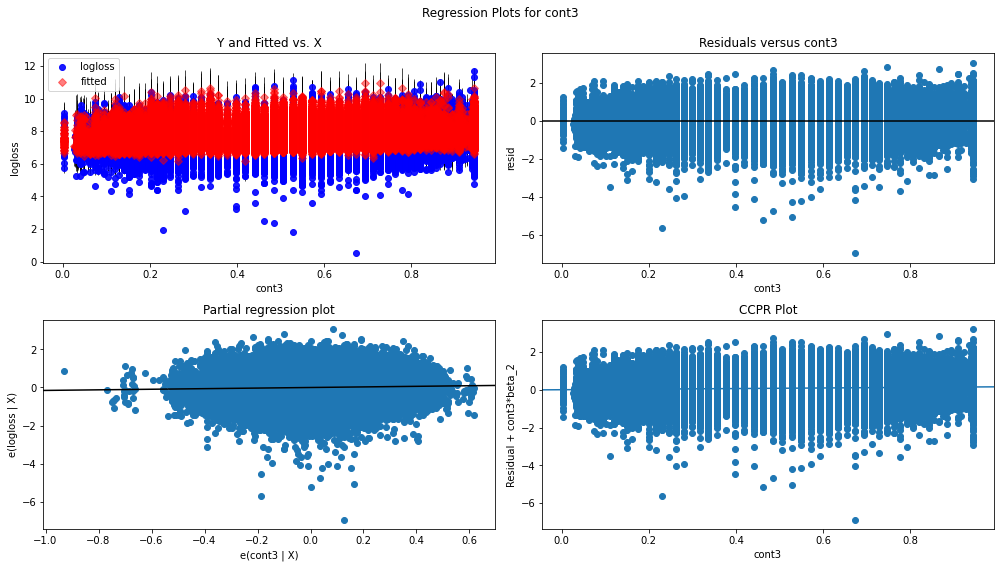

In [57]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(reduced_lin_model, 'cont3', fig=fig)

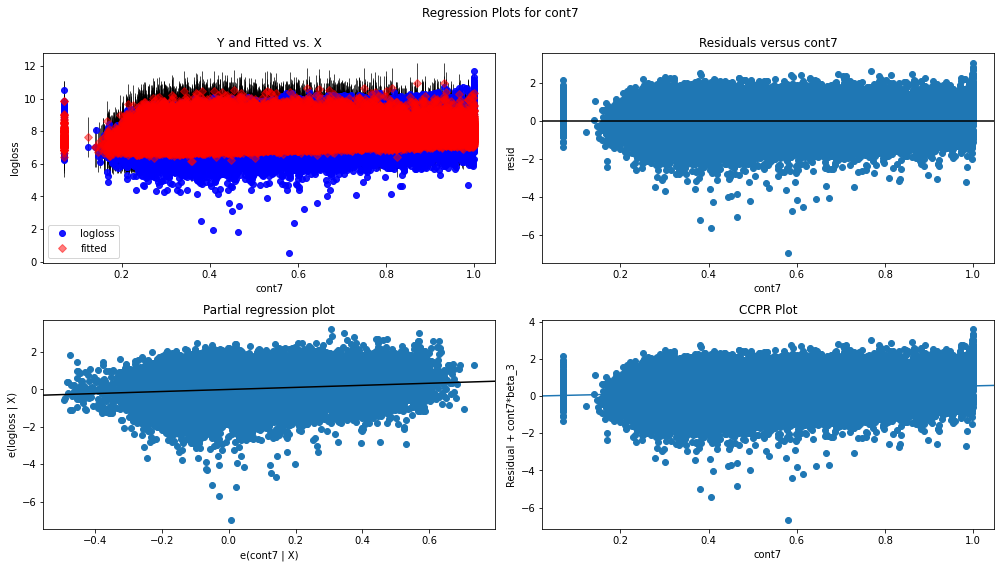

In [58]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(reduced_lin_model, 'cont7', fig=fig)

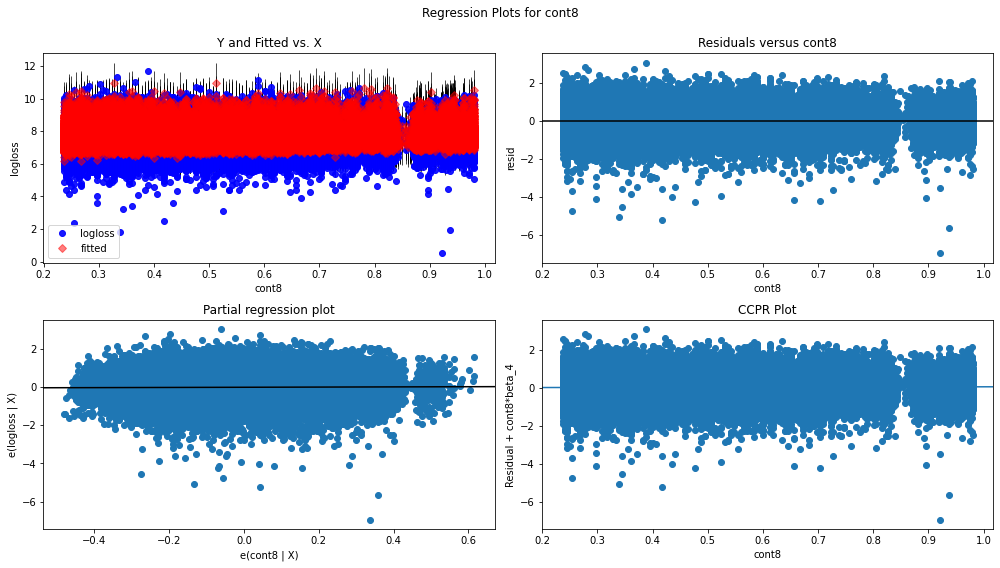

In [59]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(reduced_lin_model, 'cont8', fig=fig)

<font color=red> 
The residual plots look okay to me in general.  The residuals on cont2 look like they might be parabolic.  Going to try a polynomical fit on the cont2 variable
</font>

<a id='pol_reg'></a>
### Polynomical Regression

In [60]:
#adding polynomical variable to data
print(Xc.shape)
Xp = Xc
Xp['cont2^2'] = Xp['cont2'] ** 2
print(Xp.shape)

(112990, 56)
(112990, 57)


In [61]:
pol_model = sm.OLS(y, Xp).fit() 
pol_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logloss   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     1415.
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:58:49   Log-Likelihood:            -1.0726e+05
No. Observations:              112990   AIC:                         2.146e+05
Df Residuals:                  112934   BIC:                         2.152e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.2163      0.044    141.275      0.000       6.130       6.303
cont2               1.0348      0.043     24.239      0.000       0.951       1.118
cont3               0.1528      0.012     12.282      0.000       0.128       0.177
cont7               0.5500      0.012     46.512      0.000       0.527       0.573
cont8               0.0438      0.011      4.012      0.000       0.022       0.065
cont13             -0.1136      0.016     -7.070      0.000      -0.145      -0.082
cat1_B             -0.2316      0.005    -49.552      0.000      -0.241      -0.222
cat2_B              0.1393      0.005     25.902      0.000       0.129       0.150
cat5_B              0.1069      0.006     18.702      0.000       0.096       0.118
cat11_B             0.1237      0.008     16.422      0.000       0.109       0.138
cat14_B             0.1065      0.018      6.050      0.000       0.072       0.141
cat21_B             0.0860      0.040      2.160      0.031       0.008       0.164
cat22_B            -0.2296      0.125     -1.833      0.067      -0.475       0.016
cat23_B             0.1377      0.006     22.956      0.000       0.126       0.149
cat25_B             0.2417      0.008     31.160      0.000       0.226       0.257
cat26_B             0.2271      0.009     24.386      0.000       0.209       0.245
cat27_B             0.2026      0.007     29.579      0.000       0.189       0.216
cat29_B             0.2473      0.014     17.760      0.000       0.220       0.275
cat31_B            -0.0701      0.012     -5.787      0.000      -0.094      -0.046
cat32_B             0.3104      0.024     13.101      0.000       0.264       0.357
cat33_B             0.1186      0.026      4.492      0.000       0.067       0.170
cat35_B             0.2112      0.056      3.788      0.000       0.102       0.321
cat37_B             0.1414      0.007     19.335      0.000       0.127       0.156
cat38_B             0.2300      0.008     29.773      0.000       0.215       0.245
cat39_B            -0.0444      0.012     -3.580      0.000      -0.069      -0.020
cat41_B             0.0901      0.010      8.646      0.000       0.070       0.111
cat42_B             0.2842      0.020     14.043      0.000       0.245       0.324
cat44_B             0.2567      0.008     30.760      0.000       0.240       0.273
cat48_B             0.2335      0.049      4.721      0.000       0.137       0.331
cat57_B             0.6285      0.015     41.038      0.000       0.598       0.659
cat59_B             0.3432      0.046      7.488      0.000       0.253       0.433
cat63_B            -0.1741      0.092     -1.883      0.060      -0.355       0.007
cat67_B             0.2104      0.031      6.827      0.000       0.150       0.271
cat72_B             0.1456      0.004     35.794      0.000

<font color=red> 
the polynomial factor is significant but the adjusted R squared didnt improve much from the last regression model.  we will check MSE
</font>

In [62]:
pol_X_test = reduced_X_test
pol_X_test['cont2^2'] = pol_X_test['cont2'] ** 2
pol_X_test.shape

(75328, 57)

In [63]:
pol_predict = pol_model.predict(pol_X_test)
mse_test = metrics.mean_squared_error(y_test, pol_predict)
print(f"mse test: {np.sqrt(mse_test)}")

mse test: 0.6250671056165891


<font color=red> 
slighly better MSE than the model that doesnt includes the polynomical coefficient, but still worse than the original model.  The best model still remains the original regression
</font>

<a id='piecewise'></a>
### Piecewise Fit

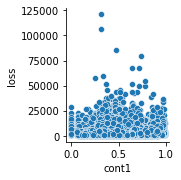

In [64]:
#based on this graph, selecting a 0.5 breakpoint on the piecewise knot
#not forcing a smooth fit
sns.pairplot(data=df_num,
                x_vars='cont1',
                y_vars='loss')

In [65]:
#splitting the independent variable
print(X_train.shape)
print(X_test.shape)

X_train1 = X_train
X_test1 = X_test

X_train1['piece1a'] = X_train1['cont1'].apply(lambda x: x if x<.5 else 0)
X_train1['piece1b'] = X_train1['cont1'].apply(lambda x: x if x>=.5 else 0)
X_test1['piece1a'] = X_test1['cont1'].apply(lambda x: x if x<.5 else 0)
X_test1['piece1b'] = X_test1['cont1'].apply(lambda x: x if x>=.5 else 0)
droped = ['cont1']
X_train1= X_train1.drop(columns=droped)
X_test1 =X_test1.drop(columns=droped)

print(X_train1.shape)
print(X_test1.shape)

(112990, 1079)
(75328, 1079)
(112990, 1080)
(75328, 1080)


In [66]:
#regressing on the new modeling data
piece_model = sm.OLS(y_train, X_train1).fit()
piece_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logloss   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     131.1
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:59:38   Log-Likelihood:                -94811.
No. Observations:              112990   AIC:                         1.915e+05
Df Residuals:                  112044   BIC:                         2.006e+05
Df Model:                         945                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.8460      0.351     13.822      0.000       4.159       5.533
cont2               0.2491      0.018     13.793      0.000       0.214       0.284
cont3               0.2573      0.053      4.843      0.000       0.153       0.362
cont4               0.0244      0.048      0.512      0.608      -0.069       0.118
cont5              -0.0204      0.015     -1.382      0.167      -0.049       0.009
cont6               0.1704      0.090      1.894      0.058      -0.006       0.347
cont7               0.1031      0.041      2.502      0.012       0.022       0.184
cont8               0.0622      0.022      2.855      0.004       0.019       0.105
cont9               0.1025      0.055      1.879      0.060      -0.004       0.209
cont10             -0.0257      0.067     -0.383      0.702      -0.157       0.106
cont11             -0.1685      0.102     -1.659      0.097      -0.367       0.031
cont12             -0.1038      0.130     -0.799      0.424      -0.358       0.151
cont13              0.2600      0.141      1.850      0.064      -0.015       0.535
cont14              0.0255      0.046      0.552      0.581      -0.065       0.116
cat1_B             -0.0937      0.005    -20.131      0.000      -0.103      -0.085
cat2_B              0.1825      0.090      2.022      0.043       0.006       0.359
cat3_B              0.0010      0.054      0.018      0.986      -0.104       0.106
cat4_B              0.0754      0.121      0.621      0.535      -0.163       0.313
cat5_B              0.2410      0.074      3.274      0.001       0.097       0.385
cat6_B              0.2411      0.464      0.520      0.603      -0.668       1.150
cat7_B              0.0755      0.079      0.957      0.339      -0.079       0.230
cat8_B             -0.0542      0.095     -0.569      0.569      -0.241       0.132
cat9_B             -0.0083      0.029     -0.289      0.772      -0.064       0.048
cat11_B             0.0832      0.028      2.998      0.003       0.029       0.138
cat14_B            -0.1047      0.048     -2.198      0.028      -0.198      -0.011
cat15_B             0.0059      0.126      0.046      0.963      -0.242       0.254
cat16_B            -0.0277      0.044     -0.622      0.534      -0.115       0.059
cat17_B            -0.0216      0.047     -0.462      0.644      -0.113       0.070
cat18_B            -0.0295      0.047     -0.621      0.535      -0.123       0.064
cat19_B             0.0725      0.046      1.571      0.116      -0.018       0.163
cat20_B            -0.0328      0.063     -0.523      0.601      -0.156       0.090
cat21_B            -0.1369      0.054     -2.513      0.012      -0.244      -0.030
cat22_B            -0.2917      0.112     -2.614      0.009      -0.510      -0.073
cat23_B             0.0748      0.019      3.908      0.000

In [67]:
#calculating the MSE
piece_predict = piece_model.predict(X_test1)
mse_test = metrics.mean_squared_error(y_test, piece_predict)
print(f"mse test: {np.sqrt(mse_test)}")

mse test: 0.5648447739266128


<font color=red> 
The additional of the piecewise variable adds no lift to the model
</font>

### Model Selection and Prediction

In [68]:
print(X_test.shape)
print(df_train_2.shape)

(75328, 1081)
(188318, 1079)


In [69]:
#select final model and make prediction
fin_model = lin_model
fin_predict = fin_model.predict(df_test_2)
d = {'id': ids, 'loss': fin_predict}
df_final = pd.DataFrame(data=d)
print(df_final.shape)
print(df_final.head())

(125546, 2)
   id      loss
0   4  7.279288
1   6  7.497027
2   9  9.357318
3  12  8.359534
4  15  6.632386


In [70]:
fin_model

In [71]:
#transform log prediction ot actual dollars
df_final['loss'] = np.exp(df_final['loss'])-1
print(df_final.shape)
print(df_final.head())

(125546, 2)
   id          loss
0   4   1448.954633
1   6   1801.675698
2   9  11582.281642
3  12   4269.702823
4  15    758.291796


In [72]:
#export file for load to Kaggle
df_final.to_csv('submission.csv',index=False)

<a id='kaggle'></a>
### Kaggle User Name and Submission Score

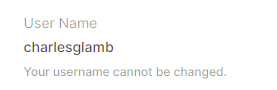

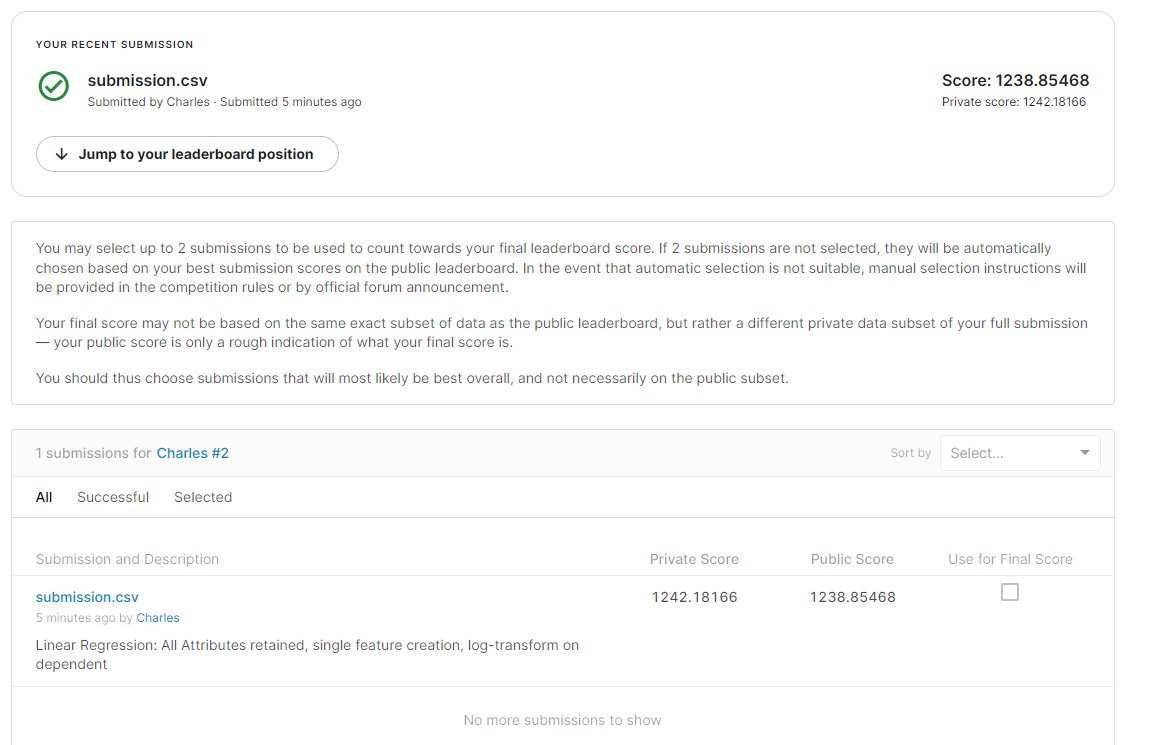

<a id='interpretation'></a>
### Model Interpretation

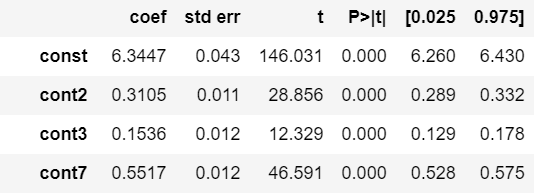

<font color=red> 
The model makes an prediction of the log of loss.  The coefficents tell us the impact of that indpendent variable has given no change in the other variables.  Take the model output from our final regression model shown above.  This tells us a 0.1 increase in "cont2", all else being equal, will increase the log of loss by 0.03105.  That represents a $1.03 increase in loss (exp**.03105) for every 0.1 increae in "cont2"

</font>

<a id='week3'></a>
# Week 3

<a id='EDA2'></a>
### EDA

<AxesSubplot:xlabel='cat10/12/13'>

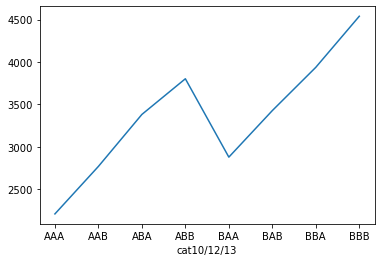

In [88]:
cat_group_1 = df_no_mild.groupby(by='cat10/12/13').mean()
cat_group_1['loss'].plot()

<AxesSubplot:xlabel='cat10'>

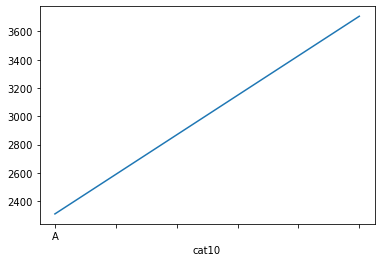

In [92]:
cat_group_2 = df_no_mild.groupby(by='cat10').mean()
cat_group_2['loss'].plot()

<AxesSubplot:xlabel='cat12'>

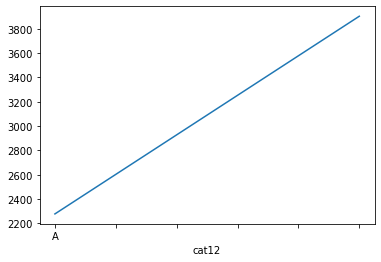

In [93]:
cat_group_3 = df_no_mild.groupby(by='cat12').mean()
cat_group_3['loss'].plot()

<AxesSubplot:xlabel='cat13'>

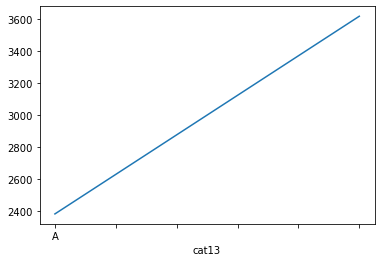

In [94]:
cat_group_4 = df_no_mild.groupby(by='cat13').mean()
cat_group_4['loss'].plot()

<a id='Lasso'></a>
### Lasso

In [73]:
#this is my first time running a lasso regression
#as such i found the hyperlink below useful in understanding how to code the approach
#https://machinelearningmastery.com/lasso-regression-with-python/

#first we optimize the hyperparameter
#we optimize by testing different hypervalues and returning the best fitting on our training data

#i am running this locally so for purposes of my limited compute, I am running this across only 2 folds, and 2 repeats
#and grid increments of 0.1

#lasso_model = Lasso()
#cross_v = RepeatedKFold(n_splits=2, n_repeats=2, random_state=1)
#grid = dict()
#grid['alpha'] = arange(0, 1, 0.1)
#search = GridSearchCV(lasso_model, grid, scoring='neg_mean_absolute_error', cv=cross_v, n_jobs=-1)
#results = search.fit(X_train, y_train)
#print(f'optimal hyperparameter: {results.best_params_}')

In [74]:
#to save processing on re-runs, i'm hardcoding in the optimized hyper parameter from the cell above
lasso_hyper = 0

In [75]:
#fit the lasso regression with optimal hyperparmeter
opt_lasso_model = Lasso(alpha=lasso_hyper)
opt_lasso_model.fit(X_train, y_train)

Lasso(alpha=0)

In [76]:
#calculating the MSE on test data
lasso_predict = opt_lasso_model.predict(X_test)
mse_test = metrics.mean_squared_error(y_test, lasso_predict)
print(f"mse test: {np.sqrt(mse_test)}")

mse test: 0.5648484374362865


<font color=red> 
nearly identical performance to our full regression model on test data

</font>

<a id='Ridge'></a>
### Ridge Regression

In [77]:
cross_v = RepeatedKFold(n_splits=2, n_repeats=2, random_state=1)
ridge_model = RidgeCV(alphas=arange(0, 1, 0.1), scoring='neg_mean_absolute_error', cv=cross_v)
ridge_model.fit(X_train, y_train)
print(f'optimal hyperparameter: {ridge_model.alpha_}')

In [78]:
#to save processing on re-runs, i'm hardcoding in the optimized hyper parameter from the cell above
ridge_hyper = .9

In [79]:
#fit the lasso regression with optimal hyperparmeter
opt_ridge_model = Ridge(alpha=ridge_hyper)
opt_ridge_model.fit(X_train, y_train)

Ridge(alpha=0.9)

In [80]:
#calculating the MSE on test data
ridge_predict = opt_ridge_model.predict(X_test)
mse_test = metrics.mean_squared_error(y_test, ridge_predict)
print(f"mse test: {np.sqrt(mse_test)}")

mse test: 0.5643622525281182


<font color=red> 
This is the best performing MSE so far

</font>

<a id='elastic'></a>
### ElasticNet Regression

In [81]:
#tunning the hyperparameter

#Elastic_model = ElasticNet()
#cross_v = RepeatedKFold(n_splits=2, n_repeats=2, random_state=1)
#grid = dict()
#grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
#grid['l1_ratio'] = arange(0, 1, 0.1)
#search = GridSearchCV(Elastic_model, grid, scoring='neg_mean_absolute_error', cv=cross_v, n_jobs=-1)
#results = search.fit(X_train, y_train)
#print('Config: %s' % results.best_params_)

<font color=red> 
commented out the model above to avoid performance issues on reruns.  the result of the query above produced an alpha of .001 and l1_ratio of .5.
    </font>

In [82]:
#fitting the model
Elastic_model = ElasticNet(alpha=0.0001, l1_ratio=0.5)
Elastic_model.fit(X_train, y_train)

ElasticNet(alpha=0.0001)

In [83]:
#calculating the MSE
elastic_predict = Elastic_model.predict(X_test)
mse_test = metrics.mean_squared_error(y_test, elastic_predict)
print(f"mse test: {np.sqrt(mse_test)}") 

mse test: 0.5638565091017481


<font color=red> 
even better MES than the ridge regression

</font>

<a id='kaggle2'></a>
### Kaggle Submission

username = charlesglamb

in week 2 we submitted our linear regression model.  in week 3, we found that the ElasticNet outperformed this model on our test data.  so we will also submit the elasticnet

In [84]:
df_test_2['piece1a'] = df_test_2['cont1'].apply(lambda x: x if x<.5 else 0)
df_test_2['piece1b'] = df_test_2['cont1'].apply(lambda x: x if x>=.5 else 0)

In [85]:
#making predictions on the Test data for elasticNet
elastic_final_predict = Elastic_model.predict(df_test_2)
d = {'id': ids, 'loss': elastic_final_predict}
df2_final = pd.DataFrame(data=d)
print(df2_final.shape)
print(df2_final.head())
df2_final['loss'] = np.exp(df2_final['loss'])-1
print(df2_final.shape)
print(df2_final.head())
df2_final.to_csv('submission2.csv',index=False)

(125546, 2)
   id      loss
0   4  7.254990
1   6  7.498184
2   9  9.361955
3  12  8.382478
4  15  6.657850
(125546, 2)
   id          loss
0   4   1414.149346
1   6   1803.762575
2   9  11636.121982
3  12   4368.823657
4  15    777.874685


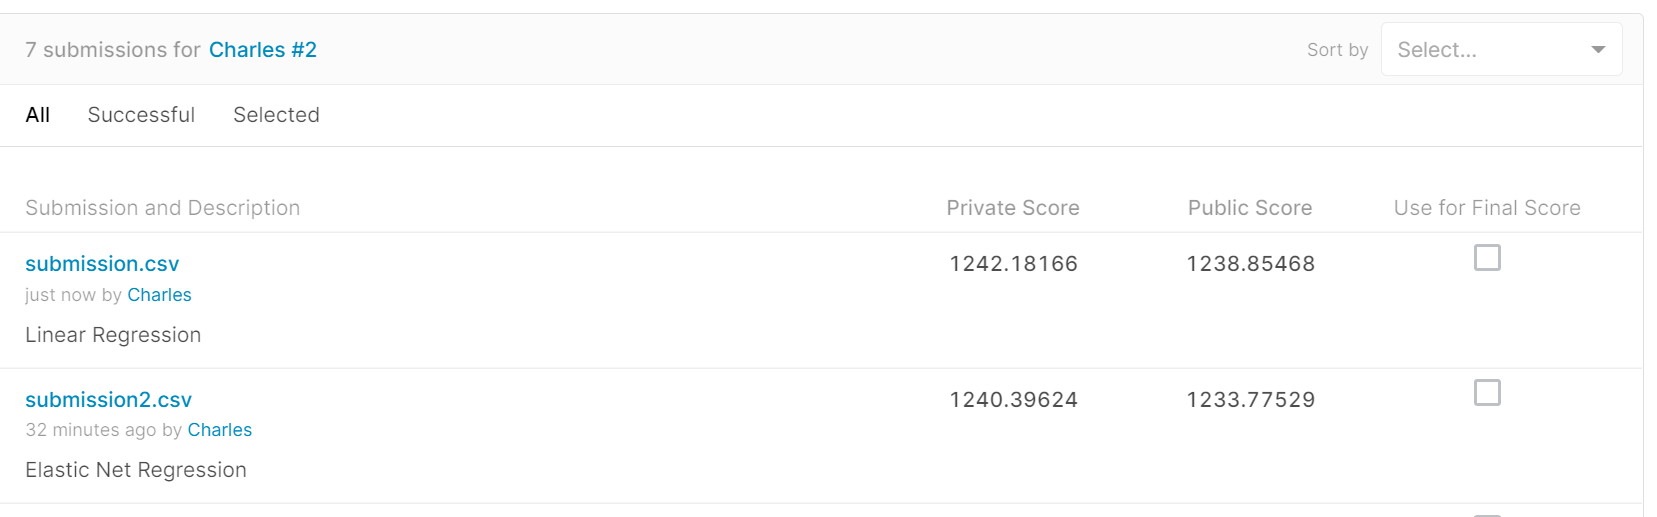